### Imports & GPU Selection

In [9]:
import matplotlib.pyplot as plt
from credentials import *
import pandas as pd
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] =  '6'

# import torch
# print(torch.cuda.is_available())


In [2]:

# should be here bc. otherwise GPU device selection is not working
from tot.methods.arc_utils import *
from tot.models import gpt_usage

In [3]:
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HF_TOKEN
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HF_TOKEN
os.environ['OPENAI_API_KEY'] = OPENAI_KEY
openai.api_key = os.getenv("OPENAI_API_KEY")

### Get Costs of OpenAI Runs

In [11]:
path = "/work/jbriem/repos/master_thesis/results/cot_objects/"
cost_data = pd.DataFrame()
for task in ["arc", "arc_1D", "arc_h_v"]:
    df = pd.read_csv(f"{path}{task}/summary.csv")
    df_filtered_1 = df[["model", "usage_total_completion_tokens", "usage_total_prompt_tokens", "usage_total_cost"]][df['model'].str.contains('gpt-3', case=False)]#.groupby("model").sum()
    df_filtered_2 = df[["model", "usage_total_completion_tokens", "usage_total_prompt_tokens", "usage_total_cost"]][df['model'].str.contains('gpt-4', case=False)]#.groupby("model").sum()
    concat = pd.concat([df_filtered_1.groupby("model").sum(), df_filtered_2.groupby("model").sum()])
    concat["task"] = task
    cost_data = pd.concat([cost_data, concat])
cost_data = cost_data.reset_index()
cost_data.to_excel(path+"cost_summary.xlsx", index=False)
cost_data

,model,usage_total_completion_tokens,usage_total_prompt_tokens,usage_total_cost,task
0,gpt-3.5-turbo-1106,20378,49090,0.089846,arc_1D
1,gpt-4-1106-preview,19422,49090,1.073560,arc_1D
2,gpt-3.5-turbo-1106,34697,79906,0.149300,arc_h_v
3,gpt-4-1106-preview,29182,79906,1.674520,arc_h_v


### Create subsets for Experiments

#### Create 1D arc subset for Experiments

In [15]:
cats  = {"1d_denoising_1c": 0.0,
#"1d_denoising_mc": 0.0,
#"1d_fill": 0.04,
#"1d_flip": 0.04,
# "1d_hollow": 0.04, # COT schon zu gut!
# "1d_mirror": 0.0,
#"1d_move_1p": 0.04,
#"1d_move_2p": 0.04,
#"1d_move_2p_dp": 0.02,
"1d_move_3p": 0.0,
#"1d_move_dp": 0.02,
#"1d_padded_fill": 0.0,
"1d_pcopy_1c": 0.0,
#"1d_pcopy_mc": 0.0,
"1d_recolor_cmp": 0.04,
#"1d_recolor_cnt": 0.0,
#"1d_recolor_oe": 0.04,
#"1d_scale_dp": 0.13725490196078433
}
sub_cats =[]
for k, v in cats.items():
    sub_cats.append(k)
sub_cats

In [16]:
# Get indices
n_rows = 50
# Calculate the number of gaps between the 9 points (first, 8 selected, last)
n_gaps = 9
# Total distance from the first to the last divided by the number of gaps
index_distance = ((n_rows-1) // n_gaps)

# Step 3: Select the rows
# Generate the indices of the rows to select
indices = [0]  # Start with the first row
current_index = 0
for i in range(1, n_gaps):
    if i % 2 == 0:  # For even i (considering i starts from 1), use base_distance + 1
        current_index += index_distance + 1
    else:  # For odd i, just use index_distance
        current_index += index_distance
    indices.append(current_index)
# indices.extend([i*index_distance if i%2==0 else i*(index_distance+1) for i in range(1, n_gaps)])  # Add the 8 selected rows
if indices[-1] != n_rows-1:  # Ensure the last row is included
    indices.append(n_rows-1)  # Adjust the last index to be the actual last row

# Select the rows based on the calculated indices
indices

In [17]:
# get ARC tasks
path = '/ARC_datasets/1D-ARC/dataset'
tasks_jsons, tasks_names, subdirecotries = load_arc_tasks(path, dataset="arc_1D")
# complexity = number of pixels in test input
complexity = [np.prod(np.array(t["test"][0]["input"]).shape) for t in tasks_jsons]
# create dataframe and add probability of task to be choosen, dependent on frequency of task's complexity in its category
tasks = pd.DataFrame({"task_name": tasks_names, "task_json": tasks_jsons, "complexity": complexity, "category": subdirecotries})
os.makedirs("/".join(path.split("/")[:-1]+["subset"]), exist_ok=True)
# delete previous files
path = "/".join(path.split("/")[:-1]+["subset"])
for entry  in os.listdir(path):
    full_path = os.path.join(path, entry)
    try:
        if os.path.isdir(full_path):
            # Use shutil.rmtree to delete the directory
            shutil.rmtree(full_path)
    except Exception as e:
        print(e)
        pass
for cat in sub_cats:
    cat_path = "/".join(path.split("/")[:-1]+["subset",cat])
    os.makedirs(cat_path, exist_ok=True)
    # get all tasks of category
    cat_tasks =     tasks[tasks["category"] == cat].sort_values("complexity")
    tasks_filtered = cat_tasks.iloc[indices]
    #save files
    for i, row in tasks_filtered.iterrows():
        with open(os.path.join(cat_path, row["task_name"]), 'w') as f:
            json.dump(row["task_json"], f, indent=4)
   



#### Create 2D arc h vs v subset for Experiments

In [18]:
cats  = {"move_h": 0.0,
"move_v": 0.0
}
sub_cats =[]
for k, v in cats.items():
    sub_cats.append(k)
sub_cats

In [19]:
# Get indices
n_rows = 50
# Calculate the number of gaps between the 9 points (first, 8 selected, last)
n_gaps = 9
# Total distance from the first to the last divided by the number of gaps
index_distance = ((n_rows-1) // n_gaps)

# Step 3: Select the rows
# Generate the indices of the rows to select
indices = [0]  # Start with the first row
current_index = 0
for i in range(1, n_gaps):
    if i % 2 == 0:  # For even i (considering i starts from 1), use base_distance + 1
        current_index += index_distance + 1
    else:  # For odd i, just use index_distance
        current_index += index_distance
    indices.append(current_index)
# indices.extend([i*index_distance if i%2==0 else i*(index_distance+1) for i in range(1, n_gaps)])  # Add the 8 selected rows
if indices[-1] != n_rows-1:  # Ensure the last row is included
    indices.append(n_rows-1)  # Adjust the last index to be the actual last row

# Select the rows based on the calculated indices
indices

[0, 5, 11, 16, 22, 27, 33, 38, 44, 49]

In [20]:
# get ARC tasks
path = '/work/jbriem/repos/master_thesis/ARC_datasets/arc_new'
tasks_jsons, tasks_names, subdirecotries = load_arc_tasks(path, dataset="arc_h_v")
# complexity = number of pixels in test input
complexity = [np.prod(np.array(t["test"][0]["input"]).shape) for t in tasks_jsons]
# create dataframe and add probability of task to be choosen, dependent on frequency of task's complexity in its category
tasks = pd.DataFrame({"task_name": tasks_names, "task_json": tasks_jsons, "complexity": complexity, "category": subdirecotries})
os.makedirs("/".join(path.split("/")[:-1]+["arc_new_subset"]), exist_ok=True)
# delete previous files
path = "/".join(path.split("/")[:-1]+["arc_new_subset"])
for entry  in os.listdir(path):
    full_path = os.path.join(path, entry)
    try:
        if os.path.isdir(full_path):
            # Use shutil.rmtree to delete the directory
            shutil.rmtree(full_path)
    except Exception as e:
        print(e)
        pass
for cat in sub_cats:
    cat_path = "/".join(path.split("/")[:-1]+["arc_new_subset",cat])
    os.makedirs(cat_path, exist_ok=True)
    # get all tasks of category
    cat_tasks = tasks[tasks["category"] == cat].sort_values("complexity")
    tasks_filtered = cat_tasks.iloc[indices]
    #save files
    for i, row in tasks_filtered.iterrows():
        with open(os.path.join(cat_path, row["task_name"]), 'w') as f:
            json.dump(row["task_json"], f, indent=4)
   



### Show tasks and save task images

In [3]:
def show_task(task, name, just_one=False):
  if just_one:
    plt.subplot(1, 2, 1); plt.imshow(grid_to_img(task[0]))
    plt.subplot(1, 2, 2); plt.imshow(grid_to_img(task[1]))
    plt.show()
  else:
    # Show task
    print("Task:", name)
    print("TRAIN:")
    for i, ex in enumerate(task["train"]):
      in_img = grid_to_img(ex["input"])
      out_img = grid_to_img(ex["output"])
      plt.subplot(1, 2, 1); plt.imshow(grid_to_img(ex["input"]))
      plt.subplot(1, 2, 2); plt.imshow(grid_to_img(ex["output"]))
      plt.show()
    print("TEST:")
    for i, ex in enumerate(task["test"]):
      in_img = grid_to_img(ex["input"])
      out_img = grid_to_img(ex["output"])
      plt.subplot(1, 2, 1); plt.imshow(grid_to_img(ex["input"]))
      plt.subplot(1, 2, 2); plt.imshow(grid_to_img(ex["output"]))
      plt.show()


In [6]:
# path = "/work/jbriem/repos/master_thesis/ARC_datasets/1D-ARC/dataset"
path = "/work/jbriem/repos/master_thesis/ARC_datasets/ARC"
# path = "/work/jbriem/repos/master_thesis/ARC_datasets/arc_new"

tasks_jsons, tasks_names, subdirecotries = load_arc_tasks(path, dataset="arc") # TODO: choose dataset= ["arc_1D", "arc", "arc_h_v"]

Total number of tasks: 800


Task: 007bbfb7.json
TRAIN:


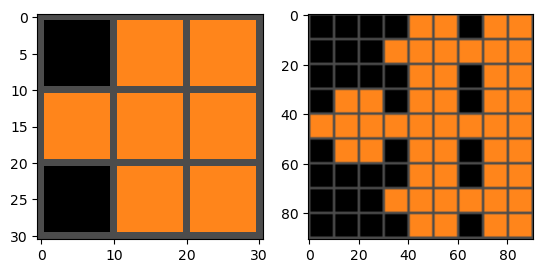

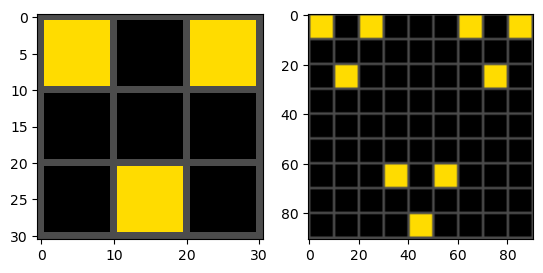

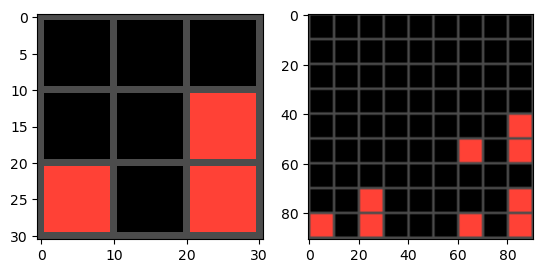

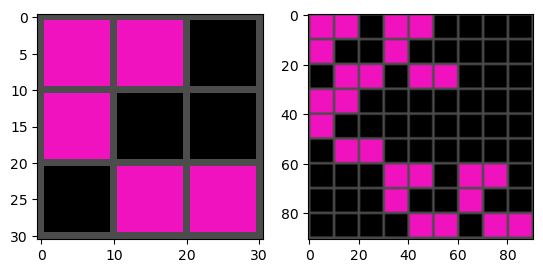

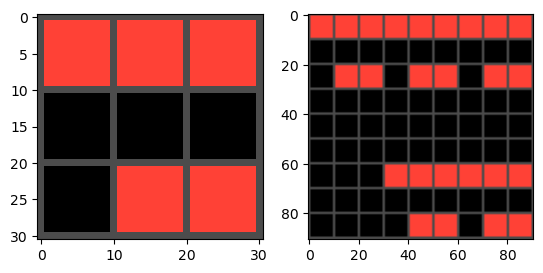

TEST:


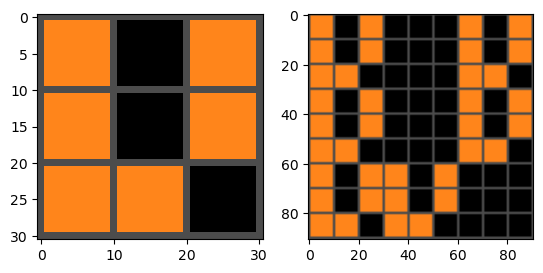

In [8]:
for task_json, name, cat in zip(tasks_jsons, tasks_names, subdirecotries):
    if name == "007bbfb7.json":
        show_task(task_json, name)
        break

In [6]:
def create_1D_examples(tasks, names, save=False):
    total_plots = len(tasks) * 2  # Each example has an input and an output
    
    # Calculate the number of rows needed for all subplots
    n_cols = 2
    n_rows = total_plots // n_cols
    
    # Calculate spacing for captions based on the figure size and number of rows
    top_margin = 0.94  # Adjust this value if necessary
    bottom_margin = 0.07  # Adjust this value if necessary
    total_vert_space = top_margin - bottom_margin   
    space_per_row = total_vert_space / n_rows
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5, n_rows * 0.55), facecolor='none')
    axs = axs.flatten()  # Flatten the array of axes for easy indexing
    for i, task in enumerate(tasks):
        in_img = grid_to_img(task["train"][0]["input"])
        out_img = grid_to_img(task["train"][0]["output"])
        
        ax = axs[i*2]
        ax.imshow(in_img)
        ax.axis('off')  # Remove the axis ticks and labels
        caption_y_position = top_margin - (i * space_per_row + 0.06)
        fig.text(0.03, caption_y_position, names[i], ha='left', fontsize=11, color='black')
        ax = axs[i*2 + 1]
        ax.imshow(out_img)
        ax.axis('off')  # Remove the axis ticks and labels
            
    # Add headers above columns
    fig.text(0.22, 0.93, 'Input', ha='center', fontsize=13, weight='bold', color='black')
    fig.text(0.78, 0.93, 'Output', ha='center', fontsize=13, weight='bold', color='black')
    
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    # Adjust the width of the padding between subplots
    plt.subplots_adjust(wspace=0.4)  # Increase the space between columns
    if save:
        plt.savefig(f'task_images/samples_1D.png', transparent=True)  # Save the figure with a transparent background
    plt.show()

    

In [11]:
arc_1D_tasks = {
    # # move 1p
    # "Move 1 Pixel": {"train": [{"input": [[0,0,1,1,1,1,1,0,0,0,0]],"output": [[0,0,0,1,1,1,1,1,0,0,0]]}],"test": []},
    # # move 2p
    # "Move 2 Pixel": {"train": [{"input": [[0,1,1,1,1,0,0,0,0,0,0]],"output": [[0,0,0,1,1,1,1,0,0,0,0]]}],"test": []},
    # # move 3p
    # "Move 3 Pixel": {"train": [{"input": [[0,0,0,1,1,1,1,0,0,0,0]],"output": [[0,0,0,0,0,0,1,1,1,1,0]]}],"test": []},
    # # move dp
    # "Move Dynamic": {"train": [{"input": [[0,1,1,1,1,0,0,0,3,0,0]],"output": [[0,0,0,0,1,1,1,1,3,0,0]]}],"test": []},
    # # # move dp 2p
    # "Move 2 Pixel Dynamic": {"train": [{"input": [[0,0,1,1,1,1,1,0,0,3,0]],"output": [[0,0,0,0,1,1,1,1,1,3,0]]}],"test": []},
    # # fill
    # "Fill": {"train": [{"input": [[0,5,0,0,0,0,0,5,0,0,0]],"output": [[0,5,5,5,5,5,5,5,0,0,0]]}],"test": []},
    # # # padded fill
    # "Padded Fill": {"train": [{"input": [[5,0,5,0,5,0,5,0,5,0,5]],"output": [[5,5,5,0,5,5,5,0,5,5,5]]}],"test": []},
    # # hollow
    # "Hollow": {"train": [{"input": [[0,4,4,4,4,4,0,0,0,0,0]],"output": [[0,4,0,0,0,4,0,0,0,0,0]]}],"test": []},
    # # flip
    # "Flip": {"train": [{"input": [[0,0,9,7,7,7,7,7,0,0,0]],"output": [[0,0,7,7,7,7,7,9,0,0,0]]}],"test": []},
    # mirror
    "Mirror": {"train": [{"input": [[0,6,6,6,0,4,0,0,0,0,0]],"output": [[0,0,0,0,0,4,0,6,6,6,0]]}],"test": []},
    # denoise 1 Color
    "Denoise 1 Color": {"train": [{"input": [[5,5,5,5,5,5,0,5,0,5,0]],"output": [[5,5,5,5,5,5,0,0,0,0,0]]}],"test": []},
    # # denoise multi color
    "Denoise Multi-Color": {"train": [{"input": [[0,5,2,5,5,5,8,5,6,5,0]],"output": [[0,5,5,5,5,5,5,5,5,5,0]]}],"test": []},
    # pattern copy 1 Color
    "Pattern Copy 1 Color": {"train": [{"input": [[8,8,8,0,0,8,0,0,0,8,0]],"output": [[8,8,8,0,8,8,8,0,8,8,8]]}],"test": []},
    # # pattern copy Multi Color
    "Pattern Copy Multi-Color": {"train": [{"input": [[4,4,4,0,0,5,0,0,0,8,0]],"output": [[4,4,4,0,5,5,5,0,8,8,8]]}],"test": []},
    # recolor by OddEven
    "Recolor by Odd/Even": {"train": [{"input": [[8,8,0,8,8,8,0,8,8,0,8]],"output": [[2,2,0,7,7,7,0,2,2,0,7]]}],"test": []},
    # recolor by Size
    "Recolor by Size": {"train": [{"input": [[1,1,1,1,0,1,0,1,1,0,1]],"output": [[4,4,4,4,0,3,0,2,2,0,3]]}],"test": []},
    # recolor by size comparison
    "Recolor by Size Comparison": {"train": [{"input": [[1,0,1,1,1,1,1,0,1,1,0]],"output": [[1,0,5,5,5,5,5,0,1,1,0]]}],"test": []},
    # scale
    "Scale": {"train": [{"input": [[0,2,2,2,0,0,0,0,9,0,0]],"output": [[0,2,2,2,2,2,2,2,9,0,0]]}],"test": []},
    }
    
tasks_names = [k for k,v in arc_1D_tasks.items()]
tasks_jsons = [v for k,v in arc_1D_tasks.items()]



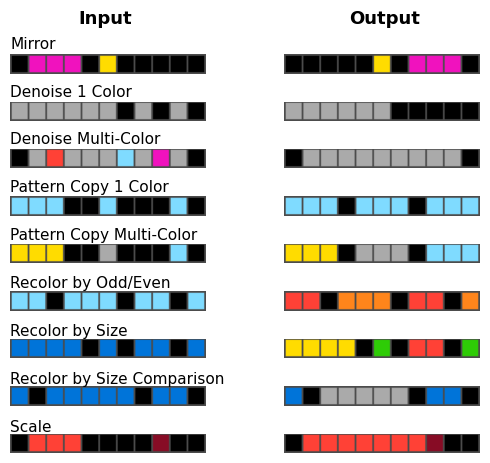

In [12]:
create_1D_examples(tasks_jsons, tasks_names, save=True)